#Preliminaries

This is the proposed pipeline of the paper **Terpsichora: an open-source repository of synthetic generated MP-Declare process models**. It contains the packages, utilities, prompts used for generation and the synthetic data generator using OpenAI API.

#Requirements

##Install dependencies

In [ ]:
!pip install cupy-cuda12x==13.2.0
!pip install declare4py==2.2.0
!pip install openai==1.35.7
!pip install pm4py==2.7.11.11
!pip install pyairports==2.1.1
!pip install pycountry==24.6.1
!pip install pydantic==2.7.4
!pip install pydantic_core==2.18.4
!pip install requests==2.31.0
!pip install requests-oauthlib==1.3.1
!pip install scipy==1.11.4
!pip install tenacity==8.4.2
!pip install termcolor==2.4.0
!pip install tiktoken==0.7.0

##Import dependencies

In [ ]:
import pandas as pd
import numpy as np
from google.colab import auth
from google.auth import default
import pm4py
import Declare4Py as dec4py
from Declare4Py.ProcessModels.DeclareModel import DeclareModel
import requests
from google.colab import userdata
from openai import OpenAI
import json
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored
from enum import Enum
import os
from typing import List, Optional, Dict, Union
from pydantic import BaseModel, Field, conlist, conint, ValidationError, field_validator, model_validator
import re
import logging
import zipfile
import random

##Utilities

This section is dedidated to set utilities to interplay with OpenAI API and set environment variables and model. It's necessary to have access to OpenAI key and have funds. You can set your OpenAI API key [here](https://platform.openai.com/settings/profile?tab=api-keys).

In [ ]:
# OpenAI environment variables configuration.
client = OpenAI(api_key=userdata.get('openai_key'))
GPT_MODEL = "gpt-4o"
os.environ["OPENAI_API_KEY"] = userdata.get('openai_key')

In [ ]:
# Utilities
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages,temperature, function_call=None, tools=None, tool_choice=None, model=GPT_MODEL):
    try:
        response = client.chat.completions.create(
            model=model,
            temperature=temperature,
            messages=messages,
            tools=tools,
            function_call=function_call,
            tool_choice=tool_choice,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e


def pretty_print_conversation(messages):
    role_to_color = {
        "system": "red",
        "user": "green",
        "assistant": "blue",
        "function": "magenta",
    }

    for message in messages:
        if message["role"] == "system":
            print(colored(f"system: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "user":
            print(colored(f"user: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "assistant" and message.get("function_call"):
            print(colored(f"assistant: {message['function_call']}\n", role_to_color[message["role"]]))
        elif message["role"] == "assistant" and not message.get("function_call"):
            print(colored(f"assistant: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "function":
            print(colored(f"function ({message['name']}): {message['content']}\n", role_to_color[message["role"]]))


# Configure the logger
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    force=True,
    handlers=[
        logging.StreamHandler()
    ]
)

# Create a logger instance
logger = logging.getLogger('MyLogger')


#Foundational Data Schema

In order to generate synthetic data models, we propose a conceptual model to represent the concepts we want to capture in form of entities and their relationships.

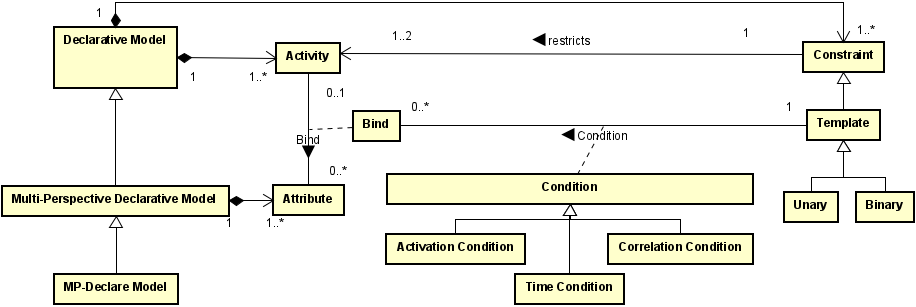

Once established the conceptual model, we need to convert it to a logical schema so it can interplay with large language models. In our case, Pydantic were used to transpose the conceptual model to a data model. In this data model we define main entities as classes, their attributes and behavior through validators of pydantic and auxiliary functions. This data schema will be useful to validate if the model outputs data that are compliant with necessary format and rules of MP-Declare model.

In [ ]:
# Activity Model
class Activity(BaseModel):
    """
    Represents an activity in a process model.

    Attributes:
        name (str): The name of the activity, following the format '<Action Verb> <Object>'.
        description (str): A detailed description of what the activity entails.
    """
    name: str = Field(
        ...,
        description="The name of the activity. Should follow the format <Action Verb> plus an <Object> and have a minimum length of 2 and at most 6 words.",
        pattern=r"^(([A-Za-z][a-z]*(?:-[A-Za-z][a-z]*)?|[A-Z]+)\s+([A-Za-z][a-z]*(?:-[A-Za-z][a-z]*)?|[A-Z]+))(\s+([A-Za-z][a-z]*(?:-[A-Za-z][a-z]*)?|[A-Z]+)){0,4}$",
    )
    description: str = Field(
        ...,
        description="A detailed description of what the activity entails.",
    )

    @field_validator('name', mode='before')
    def validate_name(cls, value):
        words = value.split()
        if len(words) < 2 or len(words) > 6:
            raise ValueError('The name must have at least 2 words and at most 6 words.')
        return value

# Attribute Model
class Attribute(BaseModel):
    """
    Represents an attribute associated with an activity.

    Attributes:
        type (str): The type of attribute. It can be integer, float or enumeration.
        name (str): The name of the attribute.
        description (str): A detailed description of what the attribute represents.
        min_value (Optional[Union[float, int]]): Minimum value for integer or float attributes.
        max_value (Optional[Union[float, int]]): Maximum value for integer or float attributes.
        enumeration_values (Optional[List[str]]): Possible values for enumeration attributes.
    """
    type: str = Field(
        ...,
        description="The type of attribute. It can be integer, float or enumeration.",
        pattern=r"^(integer|float|enumeration)$"
    )
    name: str = Field(
        ...,
        description="The name of the attribute.",
    )
    description: str = Field(
        ...,
        description="A detailed description of what the attribute represents.",
    )
    min_value: Optional[Union[float, int]] = Field(
        None,
        description="Minimum value for integer or float attributes. Should be <= than max_value."
    )
    max_value: Optional[Union[float, int]] = Field(
        None,
        description="Maximum value for integer or float attributes. Should be >= than min_value."
    )
    enumeration_values: Optional[List[str]] = Field(
        None,
        description="Possible values for enumeration attributes. Should be more than 1."
    )
    @field_validator('description', mode='before')
    def validate_description(cls, value):
        """
        Ensure description is not empty.

        Raises:
            ValueError: If description is empty.

        Returns:
            value: The validated value.
        """
        logger.debug(f"Validating description for attribute: {value}")
        if not value:
            raise ValueError("Description must not be empty.")
        return value

    @field_validator('min_value', 'max_value', mode='before')
    def check_min_max_values(cls, value, info):
        """
        Validate min_value and max_value based on the type of attribute.

        Raises:
            ValueError: If min_value or max_value are required but not provided.

        Returns:
            value: The validated value.
        """
        logger.debug(f"Validating {info.field_name} for attribute type {info.data['type']}.")
        if info.data['type'] == 'integer':
            if value is not None:
                value = int(value)
            else:
                raise ValueError(f"{info.field_name} is required for {info.data['type']} type.")
        elif info.data['type'] == 'float':
            if value is None:
                raise ValueError(f"{info.field_name} is required for {info.data['type']} type.")
        return value

    @field_validator('min_value', 'max_value', mode='after')
    def ensure_min_less_than_max(cls, value, info):
        """
        Ensure that min_value is less than or equal to max_value.

        Raises:
            ValueError: If min_value is greater than max_value.

        Returns:
            value: The validated value.
        """
        logger.debug(f"Ensuring {info.field_name} for attribute type {info.data['type']} is within valid range.")
        if info.data.get('min_value') is not None and info.data.get('max_value') is not None:
            if info.data['min_value'] > info.data['max_value']:
                raise ValueError("min_value must be less than or equal to max_value.")
        return value

    @field_validator('enumeration_values', mode='before')
    def check_enumeration_values(cls, value, info):
        """
        Validate enumeration_values for enumeration type attributes.

        Raises:
            ValueError: If enumeration_values has fewer than 2 unique items.

        Returns:
            value: The validated value.
        """
        logger.debug(f"Validating enumeration values for attribute type {info.data['type']}.")
        if info.data['type'] == 'enumeration':
            if not value or len(value) < 2:
                raise ValueError("enumeration_values must have at least 2 unique items for enumeration type.")
        return value

    @model_validator(mode='before')
    def validate_enumeration_values(cls, values):
        """
        Ensure enumeration_values is valid for enumeration type attributes.

        Raises:
            ValueError: If enumeration_values has fewer than 2 unique items.

        Returns:
            values: The validated values.
        """
        logger.debug(f"Validating attribute values: {values}")
        type_ = values.get('type')
        enumeration_values = values.get('enumeration_values')
        if type_ == 'enumeration':
            if not enumeration_values or len(enumeration_values) < 2:
                raise ValueError("enumeration_values must have at least 2 unique items for enumeration type.")
        return values

# Bind Model
class Bind(BaseModel):
    """
    Represents the binding of attributes to an activity.

    Attributes:
        activity (Activity): The activity involved in the binding.
        attributes (List[Attribute]): List of attribute objects bound to the activity.
        description (str): Description of the purpose or role of the bind.
    """
    activity: Activity = Field(
        ...,
        description="The activity involved in the binding."
    )
    attributes: conlist(Attribute, min_length=1) = Field(
        ...,
        description="List of attribute objects bound to the activity. Must have between 1 and a maximum of the total number of attributes. The attribute must have the min_value and max_value if it is integer or float and if it is enumeration it must have more than one option."
    )
    description: str = Field(
        ...,
        description="Description of the purpose or role of the bind."
    )

    @model_validator(mode='before')
    def validate_attributes(cls, values):
        """
        Ensure attributes are valid instances of Attribute.

        Raises:
            ValueError: If attributes are not valid instances of Attribute.

        Returns:
            values: The validated values.
        """
        logger.debug(f"Validating attributes for bind: {values}")
        attributes = values.get('attributes', [])
        for attribute in attributes:
            if not isinstance(attribute, Attribute):
                Attribute(**attribute)
        return values

    @field_validator('description', mode='before')
    def validate_description(cls, value):
        """
        Ensure description is not empty.

        Raises:
            ValueError: If description is empty.

        Returns:
            value: The validated value.
        """
        logger.debug(f"Validating description for bind: {value}")
        if not value:
            raise ValueError("Description must not be empty.")
        return value

# Constraint Model
class Constraint(BaseModel):
    """
    Represents a constraint in the process model.

    Attributes:
        type (str): The type of constraint. It can be unary or binary.
        description (str): A detailed description of what the constraint entails.
        template (str): The template of the constraint.
        activation (Optional[Activity]): The activation activity involved in the constraint.
        target (Optional[Activity]): The target activity involved in the constraint.
        activation_condition (Optional[str]): Condition to activate the constraint.
        correlation_condition (Optional[str]): Condition to correlate the constraint.
        time_condition (Optional[str]): Condition to specify time constraints.
        cardinality (Optional[conint(ge=1)]): The cardinality for the Existence, Absence, and Exactly templates.
        all_binds (Dict[str, Bind]): Dictionary of binds associated with the constraint.
    """
    type: str = Field(
        ...,
        description="The type of constraint. It can be unary or binary.",
        pattern=r"^(unary|binary)$"
    )
    description: str = Field(
        ...,
        description="A detailed description of what the constraint entails.The time conditions should always be described in the original measure."
    )
    template: str = Field(
        ...,
        description="The template of the constraint. If the type of the constraint is unary, the following templates are applicable: Init, End, Existence, Absence, Exactly. If it is binary template, the following are applicable: Alternate Precedence, Alternate Response, Alternate Succession, Chain Precedence, Chain Response, Chain Succession, Co-Existence, Precedence, Responded Existence, Response, Succession, Not Chain Succession, Not Co-Existence, Not Succession, Not Chain Precedence, Not Chain Response, Not Precedence, Not Responded Existence, Not Response, Choice, Exclusive Choice ",
        pattern=r"^(Init|End|Existence|Absence|Exactly|Alternate Precedence|Alternate Response|Alternate Succession|Chain Precedence|Chain Response|Chain Succession|Co-Existence|Precedence|Responded Existence|Response|Succession|Not Chain Succession|Not Co-Existence|Not Succession|Not Chain Precedence|Not Chain Response|Not Precedence|Not Responded Existence|Not Response|Choice|Exclusive Choice)$"
    )
    activation: Activity = Field(
        ...,
        description="The activation activity involved in the constraint. An activation activity is the event or activity that triggers a specific constraint or rule in the process model. It is the starting point or the condition that needs to be met for a constraint to be evaluated."
    )
    target: Optional[Activity] = Field(
        None,
        description="The target activity involved in the constraint. A target activity is the event or activity that is affected or constrained by the activation activity. It is the activity whose occurrence, timing, or order is governed by the constraint that has been activated."
    )
    activation_condition: Optional[str] = Field(
        None,
        description="Condition to activate the constraint. It must reference attributes of the activation activity and may use operations in, not in, is, is not for enumeration attributes. For integer and float it can use the following operators: ==, !=, >, >=, <, <= . And conditions can be joined using AND and OR.",
        #pattern=r"^A\.[a-zA-Z0-9_ ]+\s*(==|!=|>|>=|<|<=| in | not in | is | is not | and | or |\))"
    )
    correlation_condition: Optional[str] = Field(
        None,
        description="Condition to correlate the activation and target of the constraint. It must reference attributes of both activation and target activities and may use operations in, not in, is, is not for enumeration attributes. For integer and float it can use the following operators: ==, !=, >, >=, <, <= . And conditions can be joined using AND and OR.",
        #pattern=r"^((T|A)\.[a-zA-Z0-9_ ]+\s*(==|!=|>|>=|<|<=|is\s+not|is\s+in|not\s+in|is)\s*([a-zA-Z]+|\d+(\.\d+)?|'[^']*'|(T|A)\.[a-zA-Z0-9_ ]+)(\s+(and|or)\s+(T|A)\.[a-zA-Z0-9_ ]+\s*(==|!=|>|>=|<|<=|is\s+not|is\s+in|not\s+in|is)\s*([a-zA-Z]+|\d+(\.\d+)?|'[^']*'|(T|A)\.[a-zA-Z0-9_ ]+))*)?$"
    )
    time_condition: Optional[str] = Field(
        None,
        description="Condition to specify time between the activation and target activities. It can be in seconds, minutes, hours or days and the specification must follow the pattern.",
        pattern=r"^\d+,\d+,[smhd]$"
    )
    cardinality: Optional[conint(ge=1)] = Field(
        None,
        description="The cardinality that is mandatory for the Existence, Absence, and Exactly templates."
    )
    all_binds: Dict[str, Bind] = Field(
        default_factory=dict,
        exclude=True
    )

    @model_validator(mode='before')
    def validate_template_type_match(cls, values):
        """
        Ensure the template matches the type of the constraint.

        Args:
            values (dict): The values to validate.

        Raises:
            ValueError: If the template is not valid for the given type.

        Returns:
            dict: The validated values.
        """
        constraint_type = values.get('type')
        template = values.get('template')

        unary_templates = ["Init", "End", "Existence", "Absence", "Exactly"]
        binary_templates = ["Alternate Precedence", "Alternate Response", "Alternate Succession", "Chain Precedence", "Chain Response", "Chain Succession", "Co-Existence", "Precedence", "Responded Existence", "Response", "Succession", "Not Chain Succession", "Not Co-Existence", "Not Succession", "Not Chain Precedence", "Not Chain Response", "Not Precedence", "Not Responded Existence", "Not Response", "Choice", "Exclusive Choice"]

        logger.debug(f"Validating constraint: type={constraint_type}, template={template}")

        if constraint_type == "unary" and template not in unary_templates:
            raise ValueError(f"Invalid template '{template}' for unary constraint")
        if constraint_type == "binary" and template not in binary_templates:
            raise ValueError(f"Invalid template '{template}' for binary constraint")
        return values

    @field_validator('activation', 'target', mode='before')
    def check_activation_and_target(cls, value, info):
        """
        Validate activation and target based on the type of constraint.

        Raises:
            ValueError: If activation or target is required but not provided.

        Returns:
            value: The validated value.
        """
        logger.debug(f"Validating {info.field_name} for constraint type {info.data['type']}.")
        if info.data['type'] == 'binary':
            if info.field_name == 'activation' and value is None:
                raise ValueError("activation is required for binary type constraints.")
            if info.field_name == 'target' and value is None:
                raise ValueError("target is required for binary type constraints.")
        if info.data['type'] == 'unary' and info.field_name == 'activation' and value is None:
            raise ValueError("activation is required for unary type constraints.")
        return value



    @field_validator('cardinality', mode='before')
    def check_cardinality(cls, value, info):
        """
        Validate cardinality for Existence, Absence and Exactly templates.

        Raises:
            ValueError: If cardinality is required but not provided.

        Returns:
            value: The validated value.
        """
        logger.debug(f"Validating cardinality for template {info.data['template']}.")
        if info.data['template'] in ['Existence', 'Absence', 'Exactly'] and value is None:
            raise ValueError("cardinality is required for Existence, Absence, and Exactly templates.")
        return value

    @model_validator(mode='before')
    def validate_conditions(cls, values):
        """
        Validate conditions for constraints.

        Raises:
            ValueError: If conditions reference attributes not bound to the appropriate activities.

        Returns:
            values: The validated values.
        """
        logger.debug(f"Validating conditions for constraint with type {values.get('type')} and template {values.get('template')}")
        activation_condition = values.get('activation_condition')
        correlation_condition = values.get('correlation_condition')
        activation = values.get('activation')
        target = values.get('target')
        all_binds = values.get('all_binds', {})

        def get_condition_attributes(condition: str, prefix: str) -> set:
            if not condition:
                return set()
            pattern = re.compile(rf'\b{prefix}\.([a-zA-Z0-9_ ]+?)(?=\s*(==|!=|>|>=|<|<=|\bin\b|\bnot in\b|\bis\b|\bis not\b|\band\b|\bor\b|$))', re.IGNORECASE)
            attributes = set(m.group(1).strip() for m in re.finditer(pattern, condition))
            logger.debug(f"Extracted attributes from condition '{condition}' with prefix '{prefix}': {attributes}")
            return attributes

        def get_bound_attribute_names(activity_name: str) -> set:
            bind = all_binds.get(activity_name)
            if not bind:
                raise ValueError(f"No bind found for activity_name: {activity_name}")
            bound_attributes = set(attr.name for attr in bind.attributes)
            logger.debug(f"Bound attributes for activity '{activity_name}': {bound_attributes}")
            return bound_attributes

        if activation_condition and activation:
            logger.debug(f"Validating activation condition: {activation_condition} for activation activity: {activation.name}")
            extracted_activation_attrs = get_condition_attributes(activation_condition, 'A')
            bound_activation_attrs = get_bound_attribute_names(activation.name)
            invalid_activation_attrs = extracted_activation_attrs - bound_activation_attrs
            if invalid_activation_attrs:
                raise ValueError(f"Attributes in activation_condition {invalid_activation_attrs} are not bound to the activation activity {activation.name}")

        if correlation_condition and activation and target:
            logger.debug(f"Validating correlation condition: {correlation_condition} for activation activity: {activation.name} and target activity: {target.name}")
            extracted_activation_attrs = get_condition_attributes(correlation_condition, 'A')
            extracted_target_attrs = get_condition_attributes(correlation_condition, 'T')
            bound_activation_attrs = get_bound_attribute_names(activation.name)
            bound_target_attrs = get_bound_attribute_names(target.name)
            invalid_correlation_attrs = (extracted_activation_attrs - bound_activation_attrs) | (extracted_target_attrs - bound_target_attrs)
            if invalid_correlation_attrs:
                raise ValueError(f"Attributes in correlation_condition {invalid_correlation_attrs} are not bound to the appropriate activities")

        return values

# MPDeclareModel
class MPDeclareModel(BaseModel):
    """
    Represents a process model with activities, attributes, binds, and constraints.

    Attributes:
        activities (List[Activity]): List of activities in the process model.
        attributes (List[Attribute]): List of attributes used in the process model.
        binds (List[Bind]): List of binds that links activities and attributes used in the process model.
        constraints (List[Constraint]): List of constraints that rule the process execution.
    """
    activities: List[Activity] = Field(
        ...,
        description="List of activities used in the process model.",
        examples=[
            [
                {"name": "Log Ticket", "description": "Record a new support ticket."},
                {"name": "Assign Ticket", "description": "Assign the ticket to a support agent."},
                {"name": "Resolve Ticket", "description": "Resolve the customer's issue."},
                {"name": "Verify Resolution", "description": "Verify that the issue has been resolved."},
                {"name": "Close Ticket", "description": "Close the support ticket."},
                {"name": "Send Survey", "description": "Send a survey to the customer."},
                {"name": "Archive Ticket", "description": "Archive the ticket and related data."}
            ]
        ]
    )
    attributes: List[Attribute] = Field(
        ...,
        description="List of attributes used in the process model.",
        examples=[
            [
                {"type": "integer", "name": "Ticket ID", "description": "Unique identifier for the support ticket.", "min_value": 1, "max_value": 999999},
                {"type": "enumeration", "name": "Customer Name", "description": "Name of the customer.", "enumeration_values": ["John Doe", "Jane Smith", "Alice Johnson"]},
                {"type": "enumeration", "name": "Issue Description", "description": "Description of the issue reported by the customer.", "enumeration_values": ["Cannot login", "Payment issue", "Technical problem"]},
                {"type": "integer", "name": "Agent ID", "description": "Unique identifier for the support agent.", "min_value": 1, "max_value": 9999},
                {"type": "enumeration", "name": "Assignment Date", "description": "Date when the ticket was assigned.", "enumeration_values": ["2023-06-01", "2023-06-02", "2023-06-03"]},
                {"type": "enumeration", "name": "Resolution Details", "description": "Details of the resolution provided.", "enumeration_values": ["Password reset", "Refund processed", "Technical fix applied"]},
                {"type": "enumeration", "name": "Resolution Date", "description": "Date when the issue was resolved.", "enumeration_values": ["2023-06-04", "2023-06-05", "2023-06-06"]},
                {"type": "enumeration", "name": "Verification Status", "description": "Status of the resolution verification.", "enumeration_values": ["Verified", "Not Verified"]},
                {"type": "integer", "name": "Verifier ID", "description": "Unique identifier for the verifier.", "min_value": 1, "max_value": 9999},
                {"type": "enumeration", "name": "Close Date", "description": "Date when the ticket was closed.", "enumeration_values": ["2023-06-07", "2023-06-08", "2023-06-09"]},
                {"type": "integer", "name": "Survey ID", "description": "Unique identifier for the survey.", "min_value": 1, "max_value": 999999},
                {"type": "enumeration", "name": "Survey Date", "description": "Date when the survey was sent.", "enumeration_values": ["2023-06-10", "2023-06-11", "2023-06-12"]},
                {"type": "enumeration", "name": "Archive Date", "description": "Date when the ticket was archived.", "enumeration_values": ["2023-06-13", "2023-06-14", "2023-06-15"]}
            ]
        ]
    )
    binds: List[Bind] = Field(
        ...,
        description="List of binds that links activities and attributes used in the process model.",
        examples=[
            [
                {"activity": {"name": "Log Ticket", "description": "Record a new support ticket."}, "attributes": [{"type": "integer", "name": "Ticket ID", "description": "Unique identifier for the support ticket.", "min_value": 1, "max_value": 999999}, {"type": "enumeration", "name": "Customer Name", "description": "Name of the customer.", "enumeration_values": ["John Doe", "Jane Smith", "Alice Johnson"]}, {"type": "enumeration", "name": "Issue Description", "description": "Description of the issue reported by the customer.", "enumeration_values": ["Cannot login", "Payment issue", "Technical problem"]}], "description": "Bind Ticket ID, Customer Name, and Issue Description to 'Log Ticket' activity."},
                {"activity": {"name": "Assign Ticket", "description": "Assign the ticket to a support agent."}, "attributes": [{"type": "integer", "name": "Ticket ID", "description": "Unique identifier for the support ticket.", "min_value": 1, "max_value": 999999}, {"type": "integer", "name": "Agent ID", "description": "Unique identifier for the support agent.", "min_value": 1, "max_value": 9999}, {"type": "enumeration", "name": "Assignment Date", "description": "Date when the ticket was assigned.", "enumeration_values": ["2023-06-01", "2023-06-02", "2023-06-03"]}], "description": "Bind Ticket ID, Agent ID, and Assignment Date to 'Assign Ticket' activity."},
                {"activity": {"name": "Resolve Ticket", "description": "Resolve the customer's issue."}, "attributes": [{"type": "integer", "name": "Ticket ID", "description": "Unique identifier for the support ticket.", "min_value": 1, "max_value": 999999}, {"type": "enumeration", "name": "Resolution Details", "description": "Details of the resolution provided.", "enumeration_values": ["Password reset", "Refund processed", "Technical fix applied"]}, {"type": "enumeration", "name": "Resolution Date", "description": "Date when the issue was resolved.", "enumeration_values": ["2023-06-04", "2023-06-05", "2023-06-06"]}], "description": "Bind Ticket ID, Resolution Details, and Resolution Date to 'Resolve Ticket' activity."},
                {"activity": {"name": "Verify Resolution", "description": "Verify that the issue has been resolved."}, "attributes": [{"type": "integer", "name": "Ticket ID", "description": "Unique identifier for the support ticket.", "min_value": 1, "max_value": 999999}, {"type": "enumeration", "name": "Verification Status", "description": "Status of the resolution verification.", "enumeration_values": ["Verified", "Not Verified"]}, {"type": "integer", "name": "Verifier ID", "description": "Unique identifier for the verifier.", "min_value": 1, "max_value": 9999}], "description": "Bind Ticket ID, Verification Status, and Verifier ID to 'Verify Resolution' activity."},
                {"activity": {"name": "Close Ticket", "description": "Close the support ticket."}, "attributes": [{"type": "integer", "name": "Ticket ID", "description": "Unique identifier for the support ticket.", "min_value": 1, "max_value": 999999}, {"type": "enumeration", "name": "Close Date", "description": "Date when the ticket was closed.", "enumeration_values": ["2023-06-07", "2023-06-08", "2023-06-09"]}], "description": "Bind Ticket ID and Close Date to 'Close Ticket' activity."},
                {"activity": {"name": "Send Survey", "description": "Send a survey to the customer."}, "attributes": [{"type": "integer", "name": "Survey ID", "description": "Unique identifier for the survey.", "min_value": 1, "max_value": 999999}, {"type": "integer", "name": "Ticket ID", "description": "Unique identifier for the support ticket.", "min_value": 1, "max_value": 999999}, {"type": "enumeration", "name": "Survey Date", "description": "Date when the survey was sent.", "enumeration_values": ["2023-06-10", "2023-06-11", "2023-06-12"]}], "description": "Bind Survey ID, Ticket ID, and Survey Date to 'Send Survey' activity."},
                {"activity": {"name": "Archive Ticket", "description": "Archive the ticket and related data."}, "attributes": [{"type": "integer", "name": "Ticket ID", "description": "Unique identifier for the support ticket.", "min_value": 1, "max_value": 999999}, {"type": "enumeration", "name": "Archive Date", "description": "Date when the ticket was archived.", "enumeration_values": ["2023-06-13", "2023-06-14", "2023-06-15"]}], "description": "Bind Ticket ID and Archive Date to 'Archive Ticket' activity."}
            ]
        ]
    )
    constraints: List[Constraint] = Field(
        ...,
        description="List of constraints that rule the process execution.",
        examples=[
            [
                {"type": "unary", "description": "Ticket logging must start the process", "template": "Init", "activation": {"name": "Log Ticket", "description": "Record a new support ticket."}},
                {"type":"unary","template":"Init","description":"Plan Event must be the first activity to occur in the process.","activation":{"name":"Plan Event","description":"Plan the details of the event."}},
                {"type":"unary","template":"Init","description":"Plan Event must be the first activity to occur in the process if the event type is conference.","activation":{"name":"Plan Event","description":"Plan the details of the event."},"activation_condition":"A.Event Type is Conference"},
                {"type":"unary","template":"Init","description":"Plan Event must be the first activity to occur in the process if the event type is conference, within 24 hours.","activation":{"name":"Plan Event","description":"Plan the details of the event."},"activation_condition":"A.Event Type is Conference","time_condition":"0,24,h"},
                {"type":"unary","template":"Init","description":"Plan Event must be the first activity to occur in the process within 24 hours.","activation":{"name":"Plan Event","description":"Plan the details of the event."},"time_condition":"0,24,h"},
                {"type": "binary", "description": "Ticket assignment must occur after logging", "template": "Precedence", "activation": {"name": "Log Ticket", "description": "Record a new support ticket."}, "target": {"name": "Assign Ticket", "description": "Assign the ticket to a support agent."}},
                {"type": "binary", "description": "Ticket resolution must occur after assignment", "template": "Response", "activation": {"name": "Assign Ticket", "description": "Assign the ticket to a support agent."}, "target": {"name": "Resolve Ticket", "description": "Resolve the customer's issue."}},
                {"type": "binary", "description": "Resolution verification must immediately follow resolution", "template": "Chain Succession", "activation": {"name": "Resolve Ticket", "description": "Resolve the customer's issue."}, "target": {"name": "Verify Resolution", "description": "Verify that the issue has been resolved."}},
                {"type": "binary", "description": "Ticket must be closed within 24 hours after verification", "template": "Precedence", "activation": {"name": "Verify Resolution", "description": "Verify that the issue has been resolved."}, "target": {"name": "Close Ticket", "description": "Close the support ticket."}, "time_condition": "0,24,h"},
                {"type": "binary", "description": "Survey must be sent within 48 hours after ticket closure", "template": "Alternate Response", "activation": {"name": "Close Ticket", "description": "Close the support ticket."}, "target": {"name": "Send Survey", "description": "Send a survey to the customer."}, "time_condition": "0,48,h"},
                {"type": "unary", "description": "Process must end after ticket is archived", "template": "End", "activation": {"name": "Archive Ticket", "description": "Archive the ticket and related data."}},
                {"type":"binary","description":"Marketing strategy must be adjusted if satisfaction score is below 5","template":"Response","activation":{"name":"Analyze Feedback","description":"Analyze the collected feedback to identify areas of improvement."},"target":{"name":"Adjust Marketing Strategy","description":"Adjust the marketing strategy based on the feedback analysis."},"activation_condition":"A.Satisfaction Score < 5"},
                {"type":"binary","description":"Product must be launched only if market research is conducted in North America or Europe","template":"Precedence","activation":{"name":"Conduct Market Research","description":"Carry out market research to understand consumer preferences and trends."},"target":{"name":"Launch Product","description":"Officially launch the product in the market."},"activation_condition":"A.Market Region in (North America, Europe)"},
                {"type":"binary","template":"Chain Response","description":"Celebration must follow project completion within 48 hours.","activation":{"name":"Complete Project","description":"Finalize all project tasks and close the project."},"target":{"name":"Celebrate Success","description":"Celebrate the completion of the project with the team."},"time_condition":"0,48,h"},
                {"type":"binary","description":"Items restocking must occur after return processing in at most 2 days","template":"Chain Succession","activation":{"name":"Process Return","description":"Process the return of items by the customer."},"target":{"name":"Restock Items","description":"Restock the returned items in the warehouse."},"time_condition":"0,2,d"},
                {"type": "binary","description":"Send Invoice must happen within 30 minutes after Confirm Delivery.","template": "Precedence","activation": {"name": "Confirm Delivery","description": "Confirm the delivery of the order to the customer."},"target": {"name": "Send Invoice","description": "Send the invoice to the customer."},"time_condition": "0,30,m"},
                {"type":"binary","description":"Invoice sending must occur within 30 seconds after payment processing","template":"Chain Response","activation":{"name":"Process Payment","description":"Handle the payment for the order."},"target":{"name":"Send Invoice","description":"Send the invoice for the order to the customer."},"time_condition":"0,30,s"},
                {"type": "binary","description":"A discount will not be applied if the payment fails, the quantity is less than or equal to zero, the product is neither a computer nor a notebook, or if the product is not food and not clothes.","template": "Response","activation": {"name": "Pay","description": "Process the payment for the order."},"target": {"name": "Get Discount","description": "Apply the discount to the order."},"activation_condition":"(A.Success is false OR A.Quantity <= 0) AND A.Product not in (Computer, Notebook) OR ((A.Product is not Food) and (A.Product is not Cloths))","correlation_condition":"T.Discount = 0"},
                {"type":"binary","template":"Chain Response","description":"Evaluate Thesis must follow Assign Evaluators if the evaluator is Dr. Yellow or the thesis ID is between 9146 and 998365.","activation":{"name":"Assign Evaluators","description":"Assign evaluators for the thesis."},"target":{"name":"Evaluate Thesis","description":"Evaluate the assigned thesis."},"activation_condition":"A.Evaluator Names is Dr. Yellow OR (A.Thesis ID >= 9146 AND A.Thesis ID <= 998365)"},
                {"type":"binary","template":"Chain Response","description":"Book Flight must follow Plan Trip if the destination is not Null and the flight status is scheduled, within 5 days.","activation":{"name":"Plan Trip","description":"Plan the details of the trip."},"target":{"name":"Book Flight","description":"Book the flight for the trip."},"activation_condition":"A.Destination is not Null","correlation_condition":"T.Flight Status is Scheduled","time_condition":"0,5,d"},
                {"type":"binary","template":"Chain Response","description":"Reserve Hotel must follow Plan Trip if the destination is in Europe or Asia and the reservation status is pending, within 2 hours.","activation":{"name":"Plan Trip","description":"Plan the details of the trip."},"target":{"name":"Reserve Hotel","description":"Reserve the hotel for the trip."},"activation_condition":"A.Destination is in (Europe, Asia)","correlation_condition":"T.ReservationStatus is Pending","time_condition":"0,2,h"},
                {"type":"binary","template":"Not Chain Response","description":"Boarding must not follow Payment if the payment status is pending and the boarding status is checked in, within 10 to 30 minutes.","activation":{"name":"Payment","description":"Process the payment for the service."},"target":{"name":"Boarding","description":"Board the passenger."},"activation_condition":"A.Payment Status is Pending","correlation_condition":"T.Boarding Status is Checked In","time_condition":"10,30,m"},
                {"type":"binary","template":"Exclusive Choice","description":"Exactly one of the activities Plan Event or Cancel Event must occur in the process within 24 hours.","activation":{"name":"Plan Event","description":"Plan the details of the event."},"target":{"name":"Cancel Event","description":"Cancel the planned event."},"time_condition":"0,24,h"},
                {"type":"unary","description":"No more than 5 quality checks per process","template":"Absence","activation":{"name":"Quality Check","description":"Conduct a quality check on the refined oil."},"cardinality":5},
                {"type":"binary","description":"Refinement must be at the same refinery","template":"Responded Existence","activation":{"name":"Extract Oil","description":"Extract oil from the well."},"target":{"name":"Refine Oil","description":"Refine the transported oil."},"correlation_condition":"A.Oil Batch ID == T.Oil Batch ID"},
                {"type":"binary","description":"Additional info must be requested if the application score is between 50 and 75.","template":"Response","activation":{"name":"Review Application","description":"A reviewer assesses the submitted application."},"target":{"name":"Request Additional Info","description":"Request more information from the applicant."},"activation_condition":"A.Application Score >= 50.0 AND A.Application Score <= 75.0"},
                {"type":"unary","template":"Existence","description":"Process Payment must occur if the payment method is 'Bank Transfer' and the order amount is greater than 5000.","activation":{"name":"Process Payment","description":"Process the payment for the order."},"activation_condition":"A.Payment Method is Bank Transfer AND A.Order Amount > 5000"},
                {"type":"binary","description":"Tests of the same type must be ordered within 24 hours if ordered for the same patient","template":"Responded Existence","activation":{"name":"Order Tests","description":"Request laboratory or imaging tests for the patient."},"target":{"name":"Order Tests","description":"Request laboratory or imaging tests for the patient."},"correlation_condition":"A.Patient ID == T.Patient ID AND A.Test Type == T.Test Type","time_condition":"0,24,h"},
                {"type":"binary","description":"Follow-up visit must be scheduled within 7 days after Treatment if Treatment Type is Therapy","template":"Precedence","activation":{"name":"Administer Treatment","description":"Perform or supervise the treatment."},"target":{"name":"Follow Up Visit","description":"Schedule a follow-up visit to check on patient progress."},"activation_condition":"A.Treatment Type is Therapy","time_condition":"0,7,d"}
            ]
        ]
    )

    @model_validator(mode='before')
    def attach_binds_to_constraints(cls, values):
        """
        Attach binds to constraints in the process model.

        Raises:
            ValueError: If binds for activation and target activities are not found.

        Returns:
            values: The validated values with attached binds.
        """
        logger.debug("Attaching binds to constraints in MP-Declare Process Model")
        bind_map = {}
        for bind in values.get('binds', []):
            logger.debug(f"Processing bind for activity: {bind['activity']['name']}")
            activity = Activity(**bind['activity'])
            attributes = [Attribute(**attr) for attr in bind['attributes']]
            bind_instance = Bind(activity=activity, attributes=attributes, description=bind['description'])
            bind_map[activity.name] = bind_instance
        constraints = values.get('constraints', [])
        new_constraints = []
        for constraint_data in constraints:
            if 'activation' in constraint_data and isinstance(constraint_data['activation'], dict):
                logger.debug(f"Converting activation activity from dict to Activity for constraint with description: {constraint_data['description']}")
                constraint_data['activation'] = Activity(**constraint_data['activation'])
            if 'target' in constraint_data and isinstance(constraint_data['target'], dict):
                logger.debug(f"Converting target activity from dict to Activity for constraint with description: {constraint_data['description']}")
                constraint_data['target'] = Activity(**constraint_data['target'])

            # Filter binds for activation and target activities only
            filtered_binds = {k: v for k, v in bind_map.items() if k in [constraint_data['activation'].name, constraint_data.get('target').name if constraint_data.get('target') else None]}
            constraint_data['all_binds'] = filtered_binds

            constraint = Constraint(**constraint_data)
            new_constraints.append(constraint)
        values['constraints'] = new_constraints
        return values

    def convert_to_string(self) -> str:
        """
        Convert the process model to a string representation.

        Returns:
            str: The string representation of the process model.
        """
        # Convert activities
        activities_str = "\n".join(
            [f"activity {activity.name}" for activity in self.activities]
        )

        # Convert binds
        binds_str = "\n".join(
            [
                f"bind {bind.activity.name}: " + ", ".join([attr.name for attr in bind.attributes])
                for bind in self.binds
            ]
        )

        # Convert attributes
        attributes_str = ""
        for attribute in self.attributes:
            if attribute.type in ['integer', 'float']:
                attributes_str += f"{attribute.name}: {attribute.type} between {attribute.min_value} and {attribute.max_value}\n"
            elif attribute.type == 'enumeration':
                enumeration_values = ", ".join(attribute.enumeration_values)
                attributes_str += f"{attribute.name}: {enumeration_values}\n"

        # Convert constraints
        constraints_str = ""
        for constraint in self.constraints:
            constraint_str = ""  # Initialize constraint_str at the start of the loop
            if constraint.type == 'unary':
                if constraint.cardinality and constraint.cardinality > 1:
                    constraint_str = f"{constraint.template}{constraint.cardinality}[{constraint.activation.name}]"
                else:
                    constraint_str = f"{constraint.template}[{constraint.activation.name}]"
                constraint_str += f" |{constraint.activation_condition or ''} |{constraint.time_condition or ''}"
            elif constraint.type == 'binary':
                constraint_str = f"{constraint.template}[{constraint.activation.name}, {constraint.target.name}]"
                constraint_str += f" |{constraint.activation_condition or ''} |{constraint.correlation_condition or ''} |{constraint.time_condition or ''}"
            constraints_str += f"{constraint_str}\n"
        # Combine all parts
        final_str = "\n".join([activities_str, binds_str, attributes_str.strip(), constraints_str.strip()])

        return final_str


In [ ]:
# Inspecting the json schema
print(Constraint.model_json_schema())

#Synthetic Data Generation


In our case, we used the OpenAI API to generate synthetic data. We used the tool call/function call feature. This feature is used to get structured outputs from models through json schema. We converted the MPDeclareModel to a json schema and used it as tool call. In the end, the output of the API is parsed to the mpdeclmodel if it is compliant with the schema.

##Multimodel generation

In [ ]:
# Assistant prompt with MP-Declare knowledge.
mpdeclareknowledge="""
#**General Instructions**

You are an expert in modeling and analyzing Multi-Perspective Declare Models (MP-Declare). Your task is model a process model given a domain and high-level instructions by user.

Along with the knowledge in the function, use the knowledge below to help you understand the constraints and template semantis and condition operations while you try to specify any.

##**Constraints**

MP-Declare has two types of templates: unary and binary. Below is specified both the templates and their semantics.

###**Unary Templates**

<Unary Constraints Templates>
Constraint Template: Absence[n][Activation]
Semantics: Activation must occur at most n times in the process.

Constraint Template: Exactly[n][Activation]
Semantics: Activation must occur exactly n times in the process.

Constraint Template: Existence[n][Activation]
Semantics: Activation must occur at least n times in the process.

Constraint Template: Init[Activation]
Semantics: Activation must be the first activity to occur in the process.

Constraint Template: End[Activation]
Semantics: Activation must be the last activity to occur in the process.
</Unary Constraints Templates>

###**Binary Templates**
####**Binary Positive Templates**

<Binary Positive Templates>
Constraint Template: Alternate Precedence[Target, Activation]
Semantics: If Target occurs, then Activation must have occurred before Target, and no Target occurs between Activation and Target.

Constraint Template: Alternate Response[Activation, Target]
Semantics: Each occurrence of Activation must be followed by Target and no Activation occurs between Activation and Target.

Constraint Template: Alternate Succession[Activation, Target]
Semantics: Each occurrence of Activation must be followed by Target, and each occurrence of Target must be preceded by Activation with no intermediate occurrences of Activation or Target.

Constraint Template: Chain Precedence[Target, Activation]
Semantics: Target can occur only if it is directly preceded by Activation.

Constraint Template: Chain Response[Activation, Target]
Semantics: Activation must be immediately followed by Target.

Constraint Template: Chain Succession[Activation, Target]
Semantics: Activation must be immediately followed by Target, and Target must be immediately preceded by Activation.

Constraint Template: Co-Existence[Activation, Target]
Semantics: If Activation occurs, then Target must also occur, and vice versa.

Constraint Template: Precedence[Target, Activation]
Semantics: Activation can occur only if it was preceded by Target.

Constraint Template: Responded Existence[Activation, Target]
Semantics: If Activation occurs, then Target must occur at some point in the process.

Constraint Template: Response[Activation, Target]
Semantics: If Activation occurs, then Target must eventually follow in the process.

Constraint Template: Succession[Activation, Target]
Semantics: Activation must be followed by Target, and Target must be preceded by Activation.
</Binary Positive Templates>

####**Binary Negative Templates**

<Binary Negative Templates>
Constraint Template: Not Chain Succession[Activation, Target]
Semantics: Activation cannot be directly followed by Target, and Target cannot be directly preceded by Activation.

Constraint Template: Not Co-Existence[Activation, Target]
Semantics: Activation and Target cannot both occur in the process.

Constraint Template: Not Succession[Activation, Target]
Semantics: Activation and Target must not occur such that Activation is followed by Targer or Target is preceded by Activation.

Constraint Template: Not Chain Precedence[Target, Activation]
Semantics: Target cannot directly follow Activation.

Constraint Template: Not Chain Response[Activation, Target]
Semantics: Activation cannot be directly followed by Target.

Constraint Template: Not Precedence[Target, Activation]
Semantics: Activation cannot be preceded by Target.

Constraint Template: Not Responded Existence[Activation, Target]
Semantics: If Activation occurs, then Targer must not occur.

Constraint Template: Not Response[Activation, Target]
Semantics: Activation must not be followed by Target.
</Binary Negative Templates>

####**Choice Templates**

<Choice Templates>
Constraint Template: Choice[Activation, Target]
Semantics: At least one of the activities Activation or Target must occur in the process.

Constraint Template: Exclusive Choice[Activation, Target]
Semantics: Exactly one of the activities Activation or Target must occur in the process.
</Choice Templates>

##**Conditions**
<Conditions>
There are three types of conditions in MP-Declare: activation, correlation and time.
<Activation and Correlation>
###**Activation and Correlation:**
<Activation Condition Example>
A.Phone Number
</Activation Condition Example>
<Correlation Condition Example>
T.Phone Number
</Correlation Condition Example>

###**Conditions Operations Guidelines**
<Conditions Operations Guidelines>
Conditions have operations on attributes and should always reference existing attributes values that are bound to the activities of the condition.

<Enumeration Operations>Operations on attribute values for enumeration: is, is not, in, not in.</Enumeration Operations>

**Examples of Operations in Enumeration Attributes:**
<Enumeration Operations Examples>
A.Transport Type is Car
A.Transport Type is not Car
A.Transport Type in (Car, Train)
A.Transport Type not in (Car, Train)

If both activation condition and correlation condition have the same attribute, == can be specified for equals, and != can be specified as different in the correlation condition section.

**Example for ==:**
<Example double equals operator>A.Transport Type == T.Transport Type</Example double equals operator>
**Example for or !=:**
<Example not equal to operator>A.Transport Type != T.Transport Type</Example not equal to operator>
</Enumeration Operations Examples>

<Integer or Float Operations>Operations on attribute values for numeric (integer or float) attribute: <, <=, =, =>, >.</Integer or Float Operations>
**Examples of Operations in Float or Integer Attributes:**
<Integer or Float Operations Examples>
A.Price > 10
A.Price <= 5
A.Price == 3
</Integer or Float Operations Examples>

<Logical Operations>Operations can be joined with 'and' and 'or'.</Logical Operations>
<Logical Operations Examples>
(T.Price <= 10) OR (T.Price > 100)
(T.Price = 10) AND (T.Transport Type is Car)
</Logical Operations Examples>

</Conditions Operations Guidelines>
</Activation and Correlation>

<Time Condition Guidelines>
The time condition must be specified as follows: min_value, max_value, measure. Where min_value and max_value are positive integers and min_value<=max_value and measure refers to the measure of time which can be s for seconds, m for minutes, h for hours or d for days.
</Time Condition Guidelines>

**Examples of Time Conditions Specification:**
<Time Condition Examples>
10,15,s
5,13,m
0,48,h
0,2,d
</Time Condition Examples>
</Conditions>
"""

In [ ]:
# List of diverse domains to generate models.
domains = [
    "Project Management",
    "Supply Chain Management",
    "Operations Management",
    "Human Resources Management",
    "Risk Management",
    "Financial Management",
    "Quality Management",
    "Strategic Management",
    "Customer Relationship Management",
    "Marketing Management",
    "Software Development",
    "IT Service Management",
    "Cybersecurity",
    "Data Management",
    "Network Management",
    "Cloud Computing",
    "IT Governance",
    "System Integration",
    "Artificial Intelligence and Machine Learning",
    "Business Intelligence",
    "Product Development",
    "Process Engineering",
    "Industrial Engineering",
    "Quality Control",
    "Maintenance Management",
    "Production Planning and Control",
    "Lean Manufacturing",
    "Automation Engineering",
    "Supply Chain Logistics",
    "Environmental Engineering",
    "Patient Care Management",
    "Medical Records Management",
    "Pharmaceutical Management",
    "Clinical Research",
    "Healthcare Administration",
    "Public Health Management",
    "Healthcare Quality Improvement",
    "Medical Equipment Management",
    "Telemedicine",
    "Health Information Systems",
    "Curriculum Development",
    "Student Management",
    "Faculty Management",
    "Educational Assessment",
    "Learning Management Systems",
    "Educational Technology",
    "Research Management",
    "Library Management",
    "Distance Learning",
    "Professional Development",
    "Investment Management",
    "Asset Management",
    "Risk Assessment",
    "Compliance and Regulatory Management",
    "Financial Planning and Analysis",
    "Accounting",
    "Auditing",
    "Treasury Management",
    "Taxation",
    "Insurance",
    "Market Research",
    "Sales Strategy",
    "Advertising and Promotion",
    "Brand Management",
    "Digital Marketing",
    "Customer Service",
    "Sales Operations",
    "E-commerce Management",
    "Product Marketing",
    "Public Relations",
    "Innovation Management",
    "Product Research",
    "Process Improvement",
    "Technology Transfer",
    "Intellectual Property Management",
    "Scientific Research",
    "Technical Documentation",
    "Prototype Development",
    "Experimentation and Testing",
    "Research Ethics",
    "Compliance Management",
    "Contract Management",
    "Intellectual Property Law",
    "Corporate Law",
    "Environmental Law",
    "Labor Law",
    "Litigation Management",
    "Regulatory Affairs",
    "Policy Development",
    "Risk and Governance",
    "Recruitment and Staffing",
    "Training and Development",
    "Performance Management",
    "Compensation and Benefits",
    "Employee Relations",
    "Workforce Planning",
    "HR Analytics",
    "Health and Safety",
    "Talent Management",
    "Organizational Development",
    "Customer Support",
    "Service Level Management",
    "Complaint Management",
    "Customer Feedback Analysis",
    "Call Center Operations",
    "Customer Retention",
    "Field Service Management",
    "Technical Support",
    "Customer Experience Management",
    "Knowledge Management",
    "Inventory Management",
    "Transportation Management",
    "Warehouse Management",
    "Procurement",
    "Order Fulfillment",
    "Demand Planning",
    "Logistics Optimization",
    "Supplier Relationship Management",
    "Distribution Management",
    "Reverse Logistics",
    "Sustainability Reporting",
    "Energy Management",
    "Waste Management",
    "Environmental Compliance",
    "Sustainable Procurement",
    "Carbon Footprint Management",
    "Environmental Risk Assessment",
    "Sustainable Product Development",
    "Green Marketing",
    "Corporate Social Responsibility",
    "Public Administration",
    "Policy Analysis",
    "Public Finance",
    "Urban Planning",
    "Social Services Management",
    "Emergency Management",
    "Public Safety",
    "E-Government",
    "Regulatory Compliance",
    "Public Health Administration",
    "Hotel Management",
    "Travel Agency Management",
    "Event Management",
    "Tourism Development",
    "Customer Service in Hospitality",
    "Food and Beverage Management",
    "Facility Management",
    "Tourism Marketing",
    "Sustainable Tourism",
    "Leisure and Recreation Management",
    "Event Planning",
    "Production Management",
    "Talent Management",
    "Marketing and Promotion",
    "Venue Management",
    "Ticketing and Sales",
    "Content Creation",
    "Intellectual Property Management",
    "Audience Development",
    "Media Management",
    "Property Management",
    "Real Estate Development",
    "Valuation and Appraisal",
    "Real Estate Marketing",
    "Facility Management",
    "Real Estate Investment",
    "Leasing Management",
    "Construction Management",
    "Urban Development",
    "Real Estate Law",
    "Crop Production",
    "Livestock Management",
    "Agricultural Technology",
    "Farm Management",
    "Agribusiness Management",
    "Soil and Water Management",
    "Agricultural Marketing",
    "Sustainable Farming",
    "Food Safety and Quality",
    "Agroecology",
    "Merchandising",
    "Store Operations",
    "Retail Marketing",
    "Supply Chain Management",
    "Customer Experience Management",
    "E-commerce Management",
    "Inventory Management",
    "Retail Analytics",
    "Sales Operations",
    "Visual Merchandising",
    "Fleet Management",
    "Transportation Planning",
    "Logistics Management",
    "Public Transit Operations",
    "Airline Management",
    "Shipping and Maritime Operations",
    "Railway Management",
    "Road Transport Management",
    "Transportation Safety",
    "Transportation Infrastructure Management",
    "E-commerce Development",
    "Digital Content Creation",
    "Search Engine Optimization",
    "Social Media Management",
    "Mobile App Development",
    "Web Development",
    "User Experience Design",
    "Data Analysis",
    "Digital Transformation",
    "Innovation Strategy",
    "Business Process Reengineering",
    "Change Management",
    "Knowledge Management",
    "Product Lifecycle Management",
    "Sustainable Development",
    "Corporate Governance",
    "Ethical Hacking",
    "Penetration Testing",
    "Data Privacy",
    "Network Security",
    "Software Testing",
    "System Architecture",
    "Database Administration",
    "Middleware Management",
    "Virtualization",
    "DevOps",
    "Agile Project Management",
    "Scrum Management",
    "Lean Startup",
    "Kanban",
    "Six Sigma",
    "Operational Excellence",
    "Business Continuity Planning",
    "Disaster Recovery Planning",
    "Incident Management",
    "Problem Management",
    "Change Control",
    "Configuration Management",
    "Release Management",
    "Service Desk Management",
    "Vendor Management",
    "Contract Negotiation",
    "Outsourcing Management",
    "Offshoring Management",
    "Crisis Management",
    "Public Relations Crisis Management",
    "Media Relations",
    "Investor Relations",
    "Stakeholder Engagement",
    "Corporate Social Responsibility Reporting",
    "Ethical Marketing",
    "Green IT",
    "Energy Efficiency",
    "Sustainable Supply Chain",
    "Circular Economy",
    "Environmental Impact Assessment",
    "Climate Change Mitigation",
    "Renewable Energy Management",
    "Carbon Trading",
    "Sustainable Urban Development",
    "Smart Cities",
    "Environmental Policy",
    "Biodiversity Conservation",
    "Water Resource Management",
    "Waste-to-Energy",
    "Pollution Control",
    "Environmental Health",
    "Occupational Health and Safety",
    "Ergonomics",
    "Wellness Programs",
    "Employee Assistance Programs",
    "Diversity and Inclusion",
    "Workplace Culture",
    "Employee Engagement",
    "Leadership Development",
    "Succession Planning",
    "Conflict Resolution",
    "Organizational Change Management",
    "Corporate Training",
    "Learning and Development",
    "Instructional Design",
    "E-learning",
    "Blended Learning",
    "Talent Acquisition",
    "Employer Branding",
    "HR Compliance",
    "HR Metrics and Analytics",
    "HR Information Systems",
    "Payroll Management",
    "Benefits Administration",
    "Labor Relations",
    "Union Negotiations",
    "Industrial Relations",
    "Employee Retention",
    "Performance Appraisal",
    "Behavioral Management",
    "Organizational Behavior",
    "Workforce Diversity",
    "Human Capital Management",
    "Employee Benefits",
    "Pension Fund Management",
    "Retirement Planning",
    "Health Insurance Management",
    "Disability Management",
    "Employee Wellness",
    "Mental Health in the Workplace",
    "Substance Abuse Management",
    "Work-life Balance Programs",
    "Telecommuting",
    "Flexible Work Arrangements",
    "Remote Work Management",
    "Freelance Management",
    "Gig Economy Management",
    "Independent Contractors Management",
    "Co-working Spaces Management",
    "Digital Nomad Management",
    "Workplace Safety",
    "Emergency Response Planning",
    "Business Ethics",
    "Corporate Citizenship",
    "Social Impact Measurement",
    "Corporate Volunteering",
    "Philanthropy Management",
    "Nonprofit Management",
    "Grant Writing",
    "Fundraising",
    "Charitable Giving",
    "Social Enterprise Management",
    "Impact Investing",
    "Microfinance",
    "Community Development",
    "Social Innovation",
    "Civic Engagement",
    "Public Policy",
    "Advocacy",
    "Lobbying",
    "Regulatory Affairs",
    "Government Relations",
    "Policy Development",
    "Think Tank Management",
    "Policy Research",
    "Legislative Affairs",
    "Election Campaign Management",
    "Political Communication",
    "Public Opinion Research",
    "Crisis Communication",
    "Media Strategy",
    "Speechwriting",
    "Political Consulting",
    "International Relations",
    "Diplomacy",
    "Global Governance",
    "Human Rights Advocacy",
    "International Development",
    "Foreign Aid Management",
    "Peacebuilding",
    "Conflict Resolution",
    "Post-conflict Reconstruction",
    "Refugee and Asylum Policy",
    "Immigration Management",
    "Border Security",
    "International Law",
    "Trade Policy",
    "Economic Development",
    "International Business",
    "Export Management",
    "Import Management",
    "Foreign Direct Investment",
    "Global Supply Chain Management",
    "Cross-cultural Management",
    "International Marketing",
    "Global Talent Management",
    "International Finance",
    "Currency Exchange",
    "Global Mobility",
    "Expatriate Management",
    "International Taxation",
    "Transfer Pricing",
    "Trade Finance",
    "Customs Compliance",
    "Export Controls",
    "Sanctions Compliance",
    "Anti-money Laundering",
    "Counter-terrorism Financing",
    "Human Trafficking Prevention",
    "International Security",
    "Military Strategy",
    "Defense Policy",
    "Cyber Warfare",
    "Intelligence Analysis",
    "Counterintelligence",
    "Homeland Security",
    "Border Management",
    "Aviation Security",
    "Maritime Security",
    "Critical Infrastructure Protection",
    "Emergency Management",
    "Disaster Response",
    "Humanitarian Aid",
    "Disaster Risk Reduction",
    "Resilience Building",
    "Community Emergency Response",
    "Search and Rescue",
    "Firefighting",
    "Paramedics",
    "Law Enforcement",
    "Criminal Justice",
    "Corrections Management",
    "Rehabilitation Programs",
    "Probation and Parole",
    "Juvenile Justice",
    "Victim Support Services",
    "Crime Prevention",
    "Forensic Science",
    "Criminal Investigation",
    "Anti-corruption",
    "Corporate Investigations",
    "Fraud Detection",
    "White-collar Crime Investigation",
    "Money Laundering Investigations",
    "Cybercrime Investigation",
    "Intellectual Property Theft Investigation",
    "Insurance Fraud Investigation",
    "Financial Crime Investigation",
    "Organized Crime Investigation",
    "Drug Enforcement",
    "Human Trafficking Investigation",
    "Child Exploitation Investigation",
    "Elder Abuse Investigation",
    "Domestic Violence Investigation",
    "Hate Crime Investigation",
    "Terrorism Investigation",
    "Counter-terrorism Operations",
    "Hostage Negotiation",
    "Special Operations",
    "SWAT Team Management",
    "Tactical Operations",
    "Public Safety Management",
    "Community Policing",
    "Police Training",
    "Law Enforcement Leadership",
    "Internal Affairs",
    "Police Accountability",
    "Use of Force Policy",
    "Body-worn Cameras",
    "Crime Scene Investigation",
    "Evidence Management",
    "Witness Protection",
    "Criminal Profiling",
    "Behavioral Analysis",
    "Cyber Forensics",
    "Digital Evidence Management",
    "Computer Crime Investigation",
    "Network Forensics",
    "Malware Analysis",
    "Incident Response",
    "Cyber Threat Intelligence",
    "Cyber Defense",
    "Security Operations Center Management",
    "Cybersecurity Compliance",
    "Cyber Risk Management",
    "Penetration Testing",
    "Vulnerability Management",
    "Threat Hunting",
    "Security Information and Event Management",
    "Identity and Access Management",
    "Data Loss Prevention",
    "Endpoint Protection",
    "Cloud Security",
    "Application Security",
    "Mobile Security",
    "Industrial Control Systems Security",
    "Internet of Things Security",
    "Artificial Intelligence Security",
    "Blockchain Security",
    "Quantum Computing Security",
    "Biometric Security",
    "Cryptography",
    "Public Key Infrastructure",
    "Digital Rights Management",
    "Information Assurance",
    "Business Continuity Management",
    "Disaster Recovery Management",
    "Incident Management",
    "Crisis Management",
    "Emergency Response Management",
    "Physical Security",
    "Facility Security",
    "Access Control",
    "Surveillance",
    "Security Training",
    "Security Awareness",
    "Executive Protection",
    "Travel Security",
    "Event Security",
    "Crowd Management",
    "Asset Protection",
    "Loss Prevention",
    "Retail Security",
    "Bank Security",
    "Hospital Security",
    "School Security",
    "Campus Security",
    "Transportation Security",
    "Aviation Security",
    "Maritime Security",
    "Port Security",
    "Rail Security",
    "Public Transit Security",
    "Critical Infrastructure Security",
    "Energy Security",
    "Water Security",
    "Telecommunications Security",
    "Financial Services Security",
    "Healthcare Security",
    "Pharmaceutical Security",
    "Biotechnology Security",
    "Agricultural Security",
    "Food Security",
    "Supply Chain Security",
    "Logistics Security",
    "Shipping Security",
    "Warehouse Security",
    "Distribution Security",
    "Transportation Security",
    "Cargo Security",
    "Freight Security",
    "Courier Security",
    "Mail Security",
    "Package Security",
    "Delivery Security",
    "Logistics Security",
    "Supply Chain Security",
    "Logistics Security",
    "Transportation Security",
    "Ergonomics Engineering",
    "Renewable Energy Systems",
    "Geothermal Energy Management",
    "Solar Energy Management",
    "Wind Energy Management",
    "Biofuel Technology",
    "Electric Vehicle Technology",
    "Smart Grid Technology",
    "Energy Storage Systems",
    "Distributed Energy Resources",
    "Hydrogen Fuel Cell Technology",
    "Green Building Design",
    "Sustainable Architecture",
    "Urban Agriculture",
    "Vertical Farming",
    "Precision Agriculture",
    "Food Security Policy",
    "Nutrition Management",
    "Animal Welfare Management",
    "Wildlife Conservation",
    "Marine Biology",
    "Oceanography",
    "Climate Science",
    "Environmental Psychology",
    "Sustainability Science",
    "Environmental Economics",
    "Conservation Biology",
    "Ecotourism",
    "Environmental Education",
    "Social Work",
    "Human Services",
    "Child Welfare",
    "Gerontology",
    "Substance Abuse Counseling",
    "Mental Health Counseling",
    "Family Therapy",
    "School Counseling",
    "Career Counseling",
    "Community Counseling",
    "Clinical Psychology",
    "Forensic Psychology",
    "Industrial-Organizational Psychology",
    "Health Psychology",
    "Educational Psychology",
    "Developmental Psychology",
    "Sports Psychology",
    "Neuropsychology",
    "Cognitive Science",
    "Behavioral Science",
    "Sociology",
    "Anthropology",
    "Political Science",
    "Economics",
    "Philosophy",
    "History",
    "Linguistics",
    "Literature",
    "Creative Writing",
    "Film Studies",
    "Musicology",
    "Art History",
    "Theater Arts",
    "Dance Studies",
    "Cultural Studies",
    "Gender Studies",
    "Ethnic Studies",
    "Religious Studies",
    "Archaeology",
    "Museum Studies",
    "Archival Science",
    "Library Science",
    "Information Science",
    "Data Science",
    "Statistics",
    "Applied Mathematics",
    "Theoretical Mathematics",
    "Physics",
    "Chemistry",
    "Biology",
    "Biotechnology",
    "Genetic Engineering",
    "Bioinformatics",
    "Molecular Biology",
    "Cellular Biology",
    "Microbiology",
    "Virology",
    "Immunology",
    "Pharmacology",
    "Toxicology",
    "Neuroscience",
    "Biomedical Engineering",
    "Chemical Engineering",
    "Civil Engineering",
    "Mechanical Engineering",
    "Electrical Engineering",
    "Aerospace Engineering",
    "Automotive Engineering",
    "Nuclear Engineering",
    "Materials Science",
    "Robotics",
    "Mechatronics",
    "Nanotechnology"]

In [ ]:
# Main function of generation of synthetic models.
def generate_model_request(model):
    selected_domain = random.choice(domains)
    return {
        "model": model,
        "messages": [
            {
                "role": "system",
                "content": mpdeclareknowledge,
            },
            {
                "role": "user",
                "content": "Create a process model of a {selected_domain} domain with at most 10 activities, use integer, float and enumeration attributes, at most 15 constraints, using both unary and binary constraints and use time conditions.",
            },
        ],
        "tools": [
            {
                "type": "function",
                "function": {
                    "name": "MPDeclareModelGenerator",
                    "description": "The goal of this function is to generate a process model that fits the schema of an MP-Declare Model. The specification must follow these steps in order: (1) activities, (2) attributes, (3) bindings, and (4) constraints.",
                    "parameters": MPDeclareModel.model_json_schema(),
                },
            }
        ],
        "tool_choice": {
            "type": "function",
            "function": {"name": "MPDeclareModelGenerator"},
        },
    }

def save_model_to_files(model_args, model_obj, count):
    json_filename = f'model{count}.json'
    decl_filename = f'model{count}.decl'

    with open(json_filename, 'w') as json_file:
        json.dump(model_args, json_file, indent=4)

    with open(decl_filename, 'w') as decl_file:
        decl_file.write(model_obj.convert_to_string())

    logging.info(f"Successfully saved model {count} to {json_filename} and {decl_filename}")

def zip_models(n):
    zip_filename = 'models.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for i in range(1, n + 1):
            json_filename = f'model{i}.json'
            decl_filename = f'model{i}.decl'
            if os.path.exists(json_filename) and os.path.exists(decl_filename):
                zipf.write(json_filename)
                zipf.write(decl_filename)
    logging.info(f"All models zipped into {zip_filename}")
    return zip_filename

def generate_models(n, model="gpt-4o"):
    successful_models = []
    count = 0

    while len(successful_models) < n:
        try:
            request_data = generate_model_request(model)
            resp = client.chat.completions.create(**request_data)

            # Extract the arguments from the response
            arguments = resp.choices[0].message.tool_calls[0].function.arguments

            # Validate the generated model
            mpdeclmodel = MPDeclareModel.model_validate_json(arguments)

            # If validation is successful, add the model to the successful models list
            successful_models.append((arguments, mpdeclmodel))

            # Save the arguments and model to files
            count += 1
            save_model_to_files(arguments, mpdeclmodel, count)
            logging.info(f"Successfully generated and validated model {count}")

        except Exception as e:
            logging.error(f"An error occurred: {e}")
            # If an error occurs, we simply try again without incrementing the counter

    # Zip all generated models
    zip_filename = zip_models(count)
    return successful_models, zip_filename

# Example usage
if __name__ == "__main__":
    n = 1 #Number of models to generate
    models, zip_filename = generate_models(n)
    for i, (arguments, model) in enumerate(models):
        logging.info(f"Model {i+1}:")
        logging.info(f"Arguments: {arguments}")
        logging.info(f"Model: {model.convert_to_string()}")
    logging.info(f"Models are zipped into {zip_filename}")


#Declare4py Object Instantiation

It's important to note that the MPDeclareModel object are not compliant to declare4py objects. Hence, we need to instantiate it. In the foundational data model we created a function that converts the instance of it to a string. Here, we extend the class DeclareModel from declare4py to add two new methods that were not previously implemented: get attributes and get binds. These methods will be useful to interface with prompts.

In [ ]:
# Extend class DeclareModel to add new methods to return attributes and binds.
class ExtendedDeclareModel(DeclareModel):
    """
    Extended version of the DeclareModel class from declare4py.

    This class adds two new methods to retrieve attributes and binds.
    """

    def get_decl_attributes(self):
        """
        Retrieve the list of attributes.

        This method iterates through the attributes list of the parsed model,
        collects attribute names and their values (if present), and returns a
        formatted list of attributes.

        Returns:
            list: A list of strings representing the attributes.
        """
        attributes = []
        for attr_name, attr_obj in self.parsed_model.attributes_list.items():
            attr_value = ""
            if attr_obj.attr_value:
                attr_value = ": " + attr_obj.attr_value.value_original
            attributes.append(f"{attr_name}{attr_value}")
        return attributes

    def get_decl_binds(self):
        """
        Retrieve the list of binds.

        This method iterates through the events in the parsed model, collects
        event names and their bound attributes, and returns a formatted list of
        binds.

        Returns:
            list: A list of strings representing the  binds.
        """
        binds = []
        for event_type, events in self.parsed_model.events.items():
            for event_name, event_obj in events.items():
                if event_obj.attributes:
                    bound_attrs = ", ".join(attr_obj.get_name() for attr_obj in event_obj.attributes.values())
                    binds.append(f"bind {event_name}: {bound_attrs}")
        return binds


In [ ]:
#Instanciating the ExtendedDeclareModel with the string of the MPDeclareModel.
declare_model = ExtendedDeclareModel().parse_from_string(mpdeclmodel.convert_to_string())

# Fetching activities, constraints, attributes, and binds from the model
model_activities = declare_model.get_model_activities()
model_attributes = declare_model.get_decl_attributes()
model_binds = declare_model.get_decl_binds()
model_constraints = declare_model.get_decl_model_constraints()
print("Generated MP-Declare Model Constructs")
# Printing model activities
print("Model activities:")
print("-----------------")
for idx, act in enumerate(model_activities):
    print(idx, act)
print("\n")

# Printing model attributes
print("Model attributes:")
print("-----------------")
for idx, attr in enumerate(model_attributes):
    print(idx, attr)
print("\n")

# Printing model binds
print("Model binds:")
print("-------------")
for idx, bind in enumerate(model_binds):
    print(idx, bind)
print("\n")

# Printing model constraints
print("Model constraints:")
print("-----------------")
for idx, constr in enumerate(model_constraints):
    print(idx, constr)
print("\n")
